<a href="https://colab.research.google.com/github/soopark0221/korean_sentiment_analysis/blob/main/Naver_sentiment_kobert_psy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load dataset

In [ ]:
pip install transformers 

     |████████████████████████████████| 1.5MB 8.2MB/s 
     |████████████████████████████████| 2.9MB 30.6MB/s 
     |████████████████████████████████| 890kB 41.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=0aa0942a055c3fde509712877f3da7b35b9e3a06fb1b2a9cdfe07c1e721b333d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!git clone https://github.com/SKTBrain/KoBERT.git
%cd KoBERT
!pip install -r requirements.txt
!pip install .

Cloning into 'KoBERT'...
remote: Enumerating objects: 155, done.
remote: Total 155 (delta 0), reused 0 (delta 0), pack-reused 155
Receiving objects: 100% (155/155), 179.81 KiB | 10.58 MiB/s, done.
Resolving deltas: 100% (82/82), done.
/content/KoBERT
     |████████████████████████████████| 55.0MB 53kB/s 
     |████████████████████████████████| 348kB 56.1MB/s 
     |████████████████████████████████| 1.1MB 49.8MB/s 
     |████████████████████████████████| 4.1MB 31.6MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp36-cp36m-linux_x86_64.whl size=588517 sha256=61fd259def96c391ba30a8c9d2c48214e37785881ad13a98b19d5e8b20507769
  Stored in directory: /root/.cache/pip/wheels/37/65/52/63032864a0f31a08b9a88569f803b5bafac8abd207fd7f7534
Successfully built gluonnlp
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
Processing /content/KoBERT
  Created wheel for kobert: filename=kobert-0.1.2-cp36-none-any.whl s

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing import sequence

from transformers import BertModel, BertTokenizer
from transformers.tokenization_utils_base import PreTrainedTokenizerBase

from kobert.pytorch_kobert import get_pytorch_kobert_model
from kobert.utils import get_tokenizer
import gluonnlp as nlp
import sklearn.metrics

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/BERT/ratings_train.txt', sep = '\t')
X = train_data.document
Y = train_data.label

x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.2, random_state=1)

print('train_data : {}. test_data : {}'.format(len(x_train), len(x_test)))

train_data : 120000. test_data : 30000


In [ ]:
x_train = [str(doc) for doc in x_train]
x_test = [str(doc) for doc in x_test]
y_train = np.array(y_train)
y_test = np.array(y_test)

check imbalance

0    75173
1    74827
Name: label, dtype: int64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


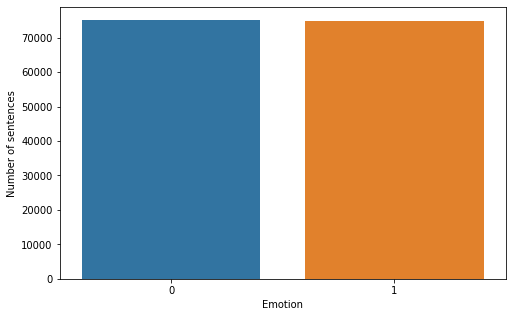

In [ ]:
count = train_data.label.value_counts()
print(count)

x = np.array(count.index)
y = np.array(count.values)
plt.figure(figsize=(8,5))
sns.barplot(x,y)
plt.xlabel('Emotion')
new = plt.ylabel('Number of sentences')

check review length

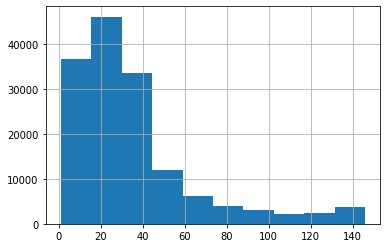

count    150000.000000
mean         35.203453
std          29.531983
min           1.000000
25%          16.000000
50%          27.000000
75%          42.000000
max         146.000000
dtype: float64

In [ ]:
review_len = [len(str(doc)) for doc in train_data.document]

pd.Series(review_len).hist()
plt.show()
pd.Series(review_len).describe()

#Preprocessing

In [ ]:
kobertmodel, vocab = get_pytorch_kobert_model()
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False) #tokenize
transform = nlp.data.BERTSentenceTransform(tok, 40, pad = True, pair = False) #embedding

[██████████████████████████████████████████████████]
[██████████████████████████████████████████████████]
using cached model


In [ ]:
def Convert_to_id(data):
  trans = [transform([i]) for i in data]
  masks = []
  ids = []
  for i in range(len(data)):
    mask = [int(j>1) for j in trans[i][0]]
    masks.append(mask)
    ids.append(trans[i][0])
  return ids, masks

In [ ]:
def Get_dataloader(x, y, batchsize):
  x_tensor = torch.tensor(Convert_to_id(x)[0], dtype= torch.long)
  a_tensor = torch.tensor(Convert_to_id(x)[1], dtype = torch.long)
  y_tensor = torch.tensor(y, dtype = torch.long)
  my_dataset = TensorDataset(x_tensor.cuda(),y_tensor.cuda(), a_tensor.cuda())
  my_dataloader = DataLoader(my_dataset, batch_size = batchsize, sampler = RandomSampler(my_dataset))
  return my_dataloader

In [ ]:
batchsize = 16
train_dataloader = Get_dataloader(x_train,y_train, batchsize)
test_dataloader = Get_dataloader(x_test, y_test, batchsize)

#Modeling

In [ ]:
class koModel(nn.Module):
  def __init__(self, kobertmodel):
    super().__init__()
    self.bert_model = kobertmodel
    self.linear = torch.nn.Linear(768,2)
  
  def forward(self, input_tensor, attention_masks):
    pooler = self.bert_model(input_ids = input_tensor, attention_mask = attention_masks)[1]
    logit = self.linear(pooler) # sequence_output, pooled_output = model(input_ids, attention_mask, token_type_ids)
    return logit

In [ ]:
model = koModel(kobertmodel)
model.cuda()

koModel(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(8002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)

#Training

In [ ]:
from torch.optim.lr_scheduler import StepLR
lr = 0.00001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)
epochs = 4
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
epochs = 4
lr = 0.000005

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)

In [ ]:
for epoch in range(epochs):
  train_loss = 0
  for x,y,a in train_dataloader:
    model.train()
    out = model(x,a)
    loss = criterion(out, y)
    loss.backward() #backprop. gradient calc
    optimizer.step() #update w
    optimizer.zero_grad() #reset gradient
    train_loss += loss.item()
  avg_train_loss = train_loss/len(x_train)
  print('epoch : {}'.format(epoch+1))
  print('avg train loss : {}'.format(avg_train_loss))
  scheduler.step()
  print('LR:', scheduler.get_last_lr()) 

  correct, total, test_loss = 0, 0, 0
  pred = []
  true = []
  for x_t,y_t,a_t in test_dataloader:
    model.eval()
    with torch.no_grad():
      testout = model(x_t,a_t)
      testloss = criterion(testout, y_t)
      _,predicted = torch.max(testout,dim=1) #torch.max returns (value, index)
      pred += predicted.tolist()
      true += y_t.tolist()
      total += y_t.size(0) #batchsize 16
      correct += (predicted == y_t).sum().item()
      test_loss += testloss.item()
  accuracy = correct/total
  f1 = sklearn.metrics.f1_score(true,pred, average = 'binary')
  recall = sklearn.metrics.recall_score(true,pred,average='binary')
  avg_test_loss = test_loss/len(x_test)
  print('avg test loss : {}'.format(avg_test_loss))
  print('accuracy: {}'.format(accuracy))
  print('f1: {}'.format(f1))
  print('recall: {}'.format(recall))
  print('----------------------------------------')

epoch : 1
avg train loss : 0.022148239044037957
train loss : 0.40798982977867126
LR: [5e-06]
avg test loss : 0.01861012154829999
test loss : 0.2673726975917816
accuracy: 0.8723333333333333
f1: 0.8763718528082632
recall: 0.9031936127744511
----------------------------------------
epoch : 2
avg train loss : 0.01539639580223399
train loss : 0.15464723110198975
LR: [2.5e-06]
avg test loss : 0.017550446188791344
test loss : 0.10765217244625092
accuracy: 0.8816
f1: 0.881946290880085
recall: 0.8827677977378576
----------------------------------------
epoch : 3
avg train loss : 0.01205063496939062
train loss : 0.12113284319639206
LR: [1.25e-06]
avg test loss : 0.018144623917900025
test loss : 0.19151873886585236
accuracy: 0.8863
f1: 0.8880428004069977
recall: 0.9000665335994678
----------------------------------------


Model Save

In [ ]:
model_path = '/content/drive/MyDrive/BERT/naverr_kobert_weights.pt'
torch.save(model.state_dict(),model_path)

#Test

In [ ]:
import pandas as pd
test = pd.read_csv('/content/drive/MyDrive/BERT/ko_data_2.csv', engine='python')

pred_list =[]
sent_test = [sent for sent in test.Id]
trans = [transform([i]) for i in sent_test]

In [ ]:
pred_list = []
for idx, s in enumerate(sent_test):
  mask = [int(j>1) for j in trans[idx][0]]
  id = trans[idx][0]
  mask=torch.tensor(mask, dtype = torch.long).unsqueeze(0).cuda()
  id = torch.tensor(id, dtype = torch.long).unsqueeze(0).cuda()
  output = model(id, mask)
  _,predicted = torch.max(output,dim=1)
  pred_list+=predicted.tolist()

[1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 

In [ ]:
pred = pd.DataFrame(pred_list, columns = ['Predicted'])
pred.to_csv('/content/drive/MyDrive/BERT/sample_naver.csv')

       Predicted
0              1
1              0
2              0
3              1
4              0
...          ...
11182          1
11183          0
11184          1
11185          1
11186          0

[11187 rows x 1 columns]
